<a href="https://colab.research.google.com/github/faranak5171/Stable-Diffusion/blob/main/Latent_DiffusionModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

adapted from : 
https://github.com/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb

https://colab.research.google.com/drive/1roZqqhsdpCXZr8kgV_Bx_ABVBPgea3lX?usp=sharing

# Stable Diffusion Initialisation

In [1]:
!pip install -q diffusers==0.8.0
!pip install -q transformers scipy ftfy accelerate lpips
!pip install -q "ipywidgets>=7,<8"

     |████████████████████████████████| 433 kB 28.2 MB/s 
     |████████████████████████████████| 182 kB 63.9 MB/s 
     |████████████████████████████████| 5.8 MB 10.1 MB/s 
     |████████████████████████████████| 53 kB 395 kB/s 
     |████████████████████████████████| 191 kB 10.5 MB/s 
     |████████████████████████████████| 53 kB 2.4 MB/s 
     |████████████████████████████████| 7.6 MB 45.0 MB/s 
     |████████████████████████████████| 1.6 MB 29.4 MB/s 


In [2]:
import os
from PIL import Image,ImageDraw
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from base64 import b64encode

import torch
from torch import autocast
from torch.nn import functional as F
from diffusers import StableDiffusionPipeline, AutoencoderKL
from diffusers import UNet2DConditionModel, PNDMScheduler, LMSDiscreteScheduler
from diffusers.schedulers.scheduling_ddim import DDIMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from tqdm.auto import tqdm
from huggingface_hub import notebook_login
from google.colab import output


In [3]:
device = 'cuda'

# Enable a Jupyter widget manager
output.enable_custom_widget_manager()
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


In [ ]:
# Load stable diffusion model to GPU
model_id = "CompVis/stable-diffusion-v1-4"
pipe = StableDiffusionPipeline.from_pretrained(model_id, revision='fp16', torch_dtype=torch.float16, use_auth_token=True)
pipe = pipe.to(device)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Downloading:   0%|          | 0.00/543 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.63k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/608M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/307 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/572 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/246M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/788 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

In [ ]:
prompt = 'cute shiba inu dog'

# autocast makes the running model a little faster
with autocast(device):
  image = pipe(prompt).images[0]
image.save("generated-image.png")

  0%|          | 0/51 [00:00<?, ?it/s]

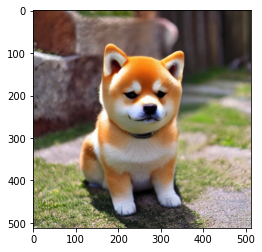

In [ ]:
img = cv2.imread('generated-image.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [4]:
# 1. Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained(
    'CompVis/stable-diffusion-v1-4', subfolder='vae', use_auth_token=True
)
vae = vae.to(device)

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/522 [00:00<?, ?B/s]

In [5]:
# 2. Load the tokenizer and text encoder to tokenize and encode the text
tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-large-patch14')
text_encoder = CLIPTextModel.from_pretrained('openai/clip-vit-large-patch14')
text_encoder = text_encoder.to(device)

Downloading:   0%|          | 0.00/961k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/905 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.11.self_attn.v_proj.bias', 'vision_model.encoder.layers.7.self_attn.q_proj.weight', 'vision_model.encoder.layers.11.mlp.fc1.weight', 'vision_model.encoder.layers.3.self_attn.out_proj.bias', 'vision_model.encoder.layers.11.self_attn.k_proj.bias', 'vision_model.encoder.layers.20.self_attn.out_proj.weight', 'vision_model.encoder.layers.1.self_attn.out_proj.weight', 'vision_model.encoder.layers.5.mlp.fc1.bias', 'vision_model.encoder.layers.10.layer_norm2.bias', 'vision_model.encoder.layers.8.self_attn.out_proj.bias', 'vision_model.encoder.layers.7.mlp.fc1.bias', 'vision_model.encoder.layers.3.layer_norm1.weight', 'vision_model.encoder.layers.19.self_attn.k_proj.weight', 'vision_model.encoder.layers.11.self_attn.v_proj.weight', 'vision_model.encoder.layers.12.self_attn.v_proj.weight', 'vision_model.encoder.layers.6.self_attn.q_proj.weight', 'visi

In [6]:
# The Unet model for generating the latents
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder='unet', use_auth_token=True)
unet = unet.to(device)

Downloading:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/743 [00:00<?, ?B/s]

In [7]:
# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# inference

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
prompt = ["fogs on stilts on a red stage"]
height = 512 #image height
width = 768 #image width
num_inference_steps = 50 #run 50 steps
guidance_scale = 7.5
generator = torch.manual_seed(4)
batch_size = 1

# Prep text , we should embeded prompt to usable space
# tokenizer text to numerical code
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
text_input["input_ids"].shape

torch.Size([1, 77])

0it [00:00, ?it/s]

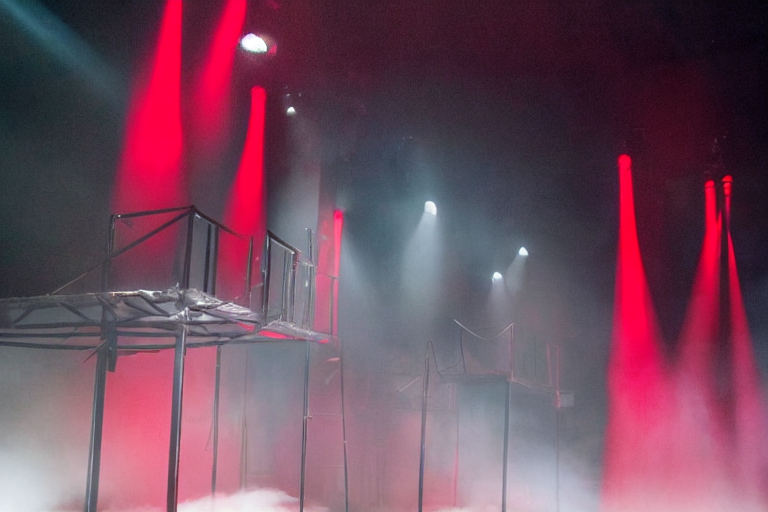

In [15]:
# we put text_input through the network twice, one with text embeddings and one without it
with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0] 

# Concate text_embedding with prompt words woth blank texts
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler to produce different number of noises
# distribute the amount of noise from 0 to 50 steps
scheduler.set_timesteps(num_inference_steps) 

# Prep latent noise, create a random number of rray
latents = torch.randn( (batch_size, unet.in_channels, height // 8, width // 8), generator=generator,)

latents = latents.to(device)
latents = latents * scheduler.sigmas[0] # Need to scale to match k

# Loop - during these 50 steps we transform a fully noisy image to a reasonable image
with autocast("cuda"):
    for i, t in tqdm(enumerate(scheduler.timesteps)): # we go through different timesteps
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        # add noise to the latent space
        latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

# Display
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]